# Introduction

**Dataset:** [IMDB](https://ai.stanford.edu/~amaas/data/sentiment/)  

**Environment**  
* Windows-native: Version `Windows10-x64-Professional-22H2`

**Framework**  
* TensorFlow: Version `2.10.1`  

**Dependencies**  
* Python: Version `3.9.19`
* Pandas: Version `2.2.2`
* Numpy: Version `1.26.4`

## What is Sequential Data?

> Whenever the points in the dataset are dependent on the other points in the dataset the data is said to be Sequential data.  
**cf. [Medium - Aashish Chaubey](https://medium.com/analytics-vidhya/sequential-data-and-the-neural-network-conundrum-b2c005f8f865)**

1. **Time Series Data**  
   stock price, weather data, ...  
   *Sequence of numbers, Sequence of geographic variables*
3. **Text Data**  
   "I am a boy."와 "Boy am i a."는 다르다 즉, 각 단어 간의 sequence가 존재함.  
   *Sequence of words*
4. **Speech Data**
5. **Video Data**  
   여러 장의 순서가 있는 Image Frame으로 연결된다.  
   *Sequence of images*
6. **Gene Sequence Data**
7. **Event Log Data**  
   어떤 Event가 또 다른 Event를 발생시키는 경우 둘은 sequence가 존재함.  
   ex. directory를 double-click하면 $\rightarrow$ 해당 directory가 open된다.

## ++

**Word Embedding**  
* 결국 Input은 numerical해야 한다. 따라서 "I am a boy.

# RNN

In [1]:
from tensorflow.keras.datasets import imdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

In [2]:
# physical_devices = tf.config.list_physical_devices('GPU')
# for device in physical_devices:
#     tf.config.experimental.set_memory_growth(device, True)

In [3]:
# # GPU 장치 목록을 가져옵니다.
# gpus = tf.config.list_physical_devices('GPU')

# if gpus:
#     try:
#         # 가상 장치의 메모리 제한을 설정합니다.
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])  # 4096 MB = 4 GB
#     except RuntimeError as e:
#         print(e)

In [4]:
# Load the datasets
# 전체 dataset에 등장하는 words중에,
# frequency가 상위 300 이내인 words만 사용.
# 여기에 포함되지 않는 token은 모두 [2]로 embedding된다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(\
    num_words=300)

In [5]:
print(f'X_train: Shape {X_train.shape}, y_train: Shape {y_train.shape}')
print(f'X_test: Shape {X_test.shape}, y_test: Shape {y_test.shape}')

# 앞선 sample dataset들과는 다르게, X가 1-dim인 것을 확인.

X_train: Shape (25000,), y_train: Shape (25000,)
X_test: Shape (25000,), y_test: Shape (25000,)


In [6]:
# Check the X
# timestep = token의 수 = 단어의 수
print(type(X_train))
for i in range(10):
    print(f'{type(X_train[i])} data instance_{i}의 timestep은 {len(X_train[i])}입니다.')

# X_train은 numpy.ndarray이지만, each X는 python list인 것을 확인.
# 그 이유는 each X마다 timestep이 다르기 때문에 즉, 가변적이기 때문에
# non-flexible한 ndarray보다는 flexible한 list가 더 적합함.

<class 'numpy.ndarray'>
<class 'list'> data instance_0의 timestep은 218입니다.
<class 'list'> data instance_1의 timestep은 189입니다.
<class 'list'> data instance_2의 timestep은 141입니다.
<class 'list'> data instance_3의 timestep은 550입니다.
<class 'list'> data instance_4의 timestep은 147입니다.
<class 'list'> data instance_5의 timestep은 43입니다.
<class 'list'> data instance_6의 timestep은 123입니다.
<class 'list'> data instance_7의 timestep은 562입니다.
<class 'list'> data instance_8의 timestep은 233입니다.
<class 'list'> data instance_9의 timestep은 130입니다.


In [7]:
# Check the y
y_train[:5]

# 1은 sentiment가 positive, 0은 sentiment가 negative

array([1, 0, 0, 1, 0], dtype=int64)

In [8]:
# X의 평균 token 수 등을 확인

# np.array([review0의 token수, review1의 token수, ...])
reviews_length = np.array([ len(x) for x in X_train ])
print(reviews_length[:5])

print(f'mean: {np.mean(reviews_length)}, median: {np.median(reviews_length)}, \
max: {np.max(reviews_length)}, min: {np.min(reviews_length)}')

[218 189 141 550 147]
mean: 238.71364, median: 178.0, max: 2494, min: 11


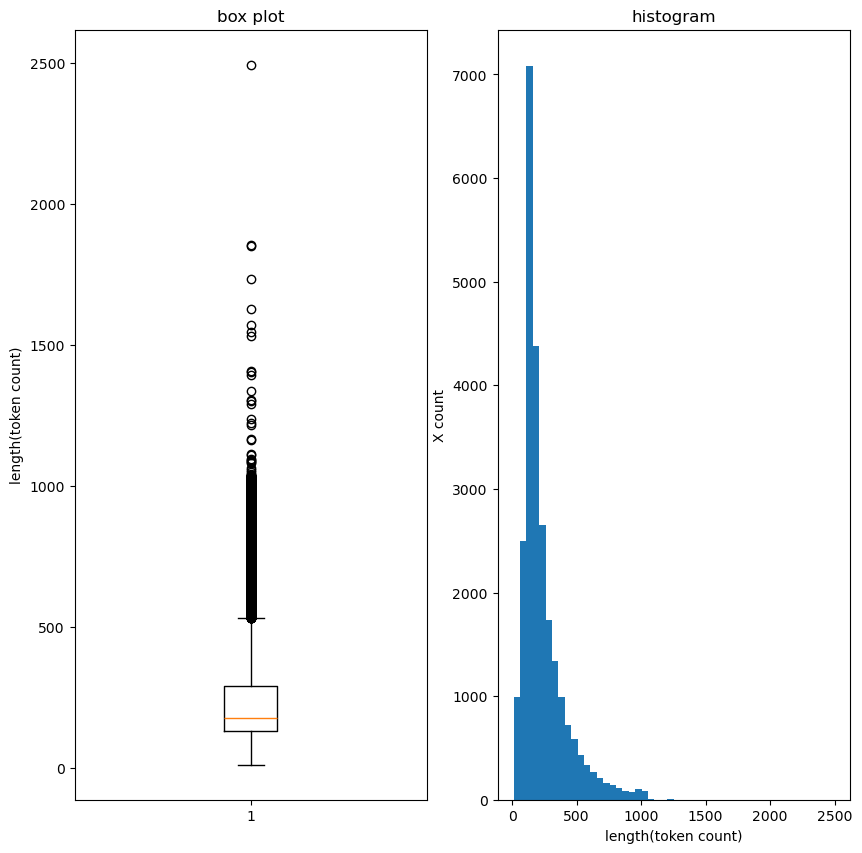

In [9]:
# plotting

# 전체 figsize 설정
figure = plt.figure(figsize=(10, 10))

# 전체 fig size를 가상으로 1개의 row, 2개의 cols로 나누고,
# 그 중 첫 번째 index에 대해서 subplot을 설정
figure.add_subplot(1, 2, 1)
plt.title('box plot')
plt.ylabel('length(token count)')
plt.boxplot(reviews_length)

# 전체 fig size를 가상으로 1개의 row, 2개의 cols로 나누고,
# 그 중 두 번째 index에 대해서 subplot을 설정
figure.add_subplot(1, 2, 2)
plt.title('histogram')
plt.xlabel('length(token count)')
plt.ylabel('X count')
plt.hist(reviews_length, bins=50)

plt.show()

**cf. [matplotlib.figure.Figure.add_subplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.figure.Figure.add_subplot.html#matplotlib.figure.Figure.add_subplot)**  
`figure.subplot(nrows, ncols, index, **kwargs)`  

**cf. [matplotlib.pyplot.boxplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html)**  
`plt.boxplot(x, **kwargs)`  
* x: Array or a sequence of vectors

**cf. [matplotlib.pyplot.hist](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html)**  
`plt.hist(x, bins=10, **kwargs)`  
* x: (n,) array or sequence of (n,) arrays
* bins: int or sequence or str, default=10  
  int인 경우, 그 값 만큼 구간을 나눔.

In [10]:
# label의 unique와 count 확인
unique_elements, count_elements = np.unique(y_train, return_counts=True)
print('frequency of each labels:')
print(np.array((unique_elements, count_elements), copy=False))

frequency of each labels:
[[    0     1]
 [12500 12500]]


In [11]:
# length(token 수)가 maxlen 이하인 X만 리턴함.
# 단 maxlen보다 짧은 경우에는 부족한 길이 만큼을 0으로 padding하여,
# maxlen으로 맞춤.
from tensorflow.keras.utils import pad_sequences

# X_train에 포함된 X중 length가 100 이하인 X들만 리턴
# 즉 기존의 length는 [218 189 141 550 147 ...]으로 non-flexible해서,
# python list에 담았지만, 이제는 100 100 100 ...으로 flexible해서,
# numpy ndarray에 보관할 수 있음
X_train = pad_sequences(X_train, maxlen=100)

print(f'X_train: Type {type(X_train)}')
print(f'X_train: Shape {X_train.shape}')
for i in range(10):
    print(f'{type(X_train[i])} data instance_{i}의 timestep은 {len(X_train[i])}입니다.')

X_train: Type <class 'numpy.ndarray'>
X_train: Shape (25000, 100)
<class 'numpy.ndarray'> data instance_0의 timestep은 100입니다.
<class 'numpy.ndarray'> data instance_1의 timestep은 100입니다.
<class 'numpy.ndarray'> data instance_2의 timestep은 100입니다.
<class 'numpy.ndarray'> data instance_3의 timestep은 100입니다.
<class 'numpy.ndarray'> data instance_4의 timestep은 100입니다.
<class 'numpy.ndarray'> data instance_5의 timestep은 100입니다.
<class 'numpy.ndarray'> data instance_6의 timestep은 100입니다.
<class 'numpy.ndarray'> data instance_7의 timestep은 100입니다.
<class 'numpy.ndarray'> data instance_8의 timestep은 100입니다.
<class 'numpy.ndarray'> data instance_9의 timestep은 100입니다.


**cf. [tf.keras.utils.pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences)**  
```python
pad_sequences(
    sequences,
    maxlen=None,
    dtype='int32',
    padding='pre', # maxlen보다 짧다면, 앞 뒤 중 어느 부분을 채울지
    truncating='pre', # maxlen보다 길다면, 앞 뒤 중 어느 부분을 자를지
    value=0.0
```

일반적으로 영화 리뷰 데이터의 경우, 리뷰의 앞 부분(pre)보다는 뒷 부분(post)에 결정적인 소감이 포함되어 있을 가능성이 높다.  
따라서 `truncating='pre'`로 설정한다.  

**cf. `tf.keras.utils.pad_sequences`와 `tensorflow.keras.preprocessing.sequence.pad_sequences`**  
**chatgpt:**  
* `tf.keras.utils.pad_sequences`: TensorFlow 2.x 버전에서 제공되며, TensorFlow의 keras 모듈의 일부로 통합되어 있습니다.
* `tensorflow.keras.preprocessing.sequence.pad_sequences`: TensorFlow 1.x 및 2.x에서 사용할 수 있지만, TensorFlow 2.x에서는 권장되는 방식이 아닙니다. 이는 tf.keras.utils로 통합된 이후에 일부 기능이 Deprecated(더 이상 사용하지 않도록 권장됨)되었기 때문입니다.

* * *
Q. 그런데 내가 알기로는 RNN은 애초에 length가 가변적이어도 상관없는데, 이렇게 100으로 맞추는 이유가 뭐야

A. RNN (Recurrent Neural Network)은 이론적으로 가변적인 길이의 시퀀스를 처리할 수 있지만, 실전에서 대부분의 RNN 모델은 고정된 길이의 입력 시퀀스를 처리할 수 있도록 설계되는 경우가 많습니다. `pad_sequences`를 사용하여 모든 시퀀스를 동일한 길이(`maxlen`)로 맞추는 이유는 다음과 같습니다:

### 1. **병렬 처리의 효율성**
   - 딥러닝 모델은 보통 GPU에서 병렬 처리를 통해 빠르게 학습합니다. 하지만 시퀀스 길이가 가변적이면 병렬 처리가 어려워집니다. 같은 크기의 배치를 만들기 위해 시퀀스 길이를 고정시키면, 모든 데이터가 동일한 크기이므로 병렬 처리가 가능해집니다. 이로 인해 학습 속도가 크게 향상됩니다.

### 2. **일괄 처리 (Batch Processing)**
   - RNN을 학습할 때는 일반적으로 여러 샘플을 하나의 배치로 묶어서 학습합니다. 이때 배치 내 모든 시퀀스가 동일한 길이를 가져야 모델이 입력을 처리할 수 있습니다. 시퀀스 길이가 다르면 배치를 구성하기 어렵고, 효율적인 학습이 불가능해집니다.

### 3. **모델 구현의 간단화**
   - 모델 코드와 구현이 단순해집니다. 시퀀스 길이가 고정되어 있으면, 모델을 구현할 때 길이 변화를 따로 처리할 필요가 없으므로 모델 구조를 간단하게 만들 수 있습니다. 특히 CNN과 함께 사용하는 경우, 고정된 입력 길이가 필수적입니다.

### 4. **메모리 사용 효율성**
   - 시퀀스 길이가 다양한 데이터를 개별적으로 처리하면 메모리 사용이 비효율적일 수 있습니다. 패딩을 통해 길이를 맞추면 메모리 사용을 예측할 수 있고, 모델이 더 안정적으로 동작합니다.

### 5. **동일한 학습 패턴**
   - RNN은 시퀀스의 시간적 의존성을 학습합니다. 시퀀스 길이가 동일하면 학습이 더 균일해지고, 모델이 더 안정적으로 수렴할 수 있습니다. 가변 길이 시퀀스를 사용하면 모델이 시퀀스의 다양한 길이에서 발생하는 불균형한 학습 패턴을 학습해야 하므로 학습이 어려워질 수 있습니다.

### 요약
RNN은 가변 길이의 입력을 처리할 수 있지만, 학습 속도, 병렬 처리 효율성, 일괄 처리의 용이성 등을 고려하여 시퀀스 길이를 고정하는 것이 일반적입니다. 이는 특히 대규모 데이터셋에서 학습할 때 중요한 요소입니다. `pad_sequences`를 사용하여 시퀀스를 동일한 길이로 맞추면, 모델이 더 효율적이고 안정적으로 학습할 수 있습니다.

* * *

In [12]:
# One-hot encoding
print(f'before: X_train: Shape {X_train.shape}')
print(X_train[:3])
print('=========================================================================')
X_train_onehot = keras.utils.to_categorical(X_train)
print(f'after: X_train_onehot: Shape {X_train_onehot.shape}')
print(X_train_onehot[:3])

before: X_train: Shape (25000, 100)
[[  2  33   6  22  12 215  28  77  52   5  14   2  16  82   2   8   4 107
  117   2  15 256   4   2   7   2   5   2  36  71  43   2   2  26   2   2
   46   7   4   2   2  13 104  88   4   2  15 297  98  32   2  56  26 141
    6 194   2  18   4 226  22  21 134   2  26   2   5 144  30   2  18  51
   36  28 224  92  25 104   4 226  65  16  38   2  88  12  16 283   5  16
    2 113 103  32  15  16   2  19 178  32]
 [163  11   2   2   4   2   9 194   2   7   2   2   2   2 148   2   2   2
   15 123 125  68   2   2  15   2 165   2  98   5   4 228   9  43   2   2
   15 299 120   5 120 174  11 220 175 136  50   9   2 228   2   5   2   2
  245   2   5   4   2 131 152   2  18   2  32   2   2  14   9   6   2  78
   22   2  64   2   9   8 168 145  23   4   2  15  16   4   2   5  28   6
   52 154   2  33  89  78 285  16 145  95]
 [  2   4   2  33  89  78  12  66  16   4   2   7   4  58   2   2  11   4
    2  43   2   2   8 257  85   2  42   2   2  83  68   2  15  3

In [13]:
# 기존
print(len(X_train[0])) # Output: 100
print(X_train[0][0]) # Output: 2
# onehot: 기존에는 [2]로 표현 가능하던 것이,
# [0 0 1 0 0 ... 0 0 0]의 길이 300으로 표현하게 됨.
print(len(X_train_onehot[0][0])) # Output: 300 # 2를 onehot으로 표시한 것의 길이
print(len(X_train_onehot[0])) # Output: 100

100
2
300
100


In [14]:
# with tf.device('/CPU:0'):
#     X_train_onehot_tensor = tf.convert_to_tensor(X_train_onehot, dtype=tf.float32)
#     y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [15]:
model1 = keras.Sequential()
model1.add(keras.layers.SimpleRNN(units=8,
                                  activation='tanh',
                                  input_shape=(100, 300)))
model1.add(keras.layers.Dense(units=1,
                              activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 2472      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 2,481
Trainable params: 2,481
Non-trainable params: 0
_________________________________________________________________


In [16]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model1.compile(optimizer=rmsprop,
               loss='binary_crossentropy',
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simple-rnn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history1 = model1.fit(X_train_onehot, y_train,
                      validation_split=0.2,
                      batch_size=32,
                      epochs=100,
                      verbose=2)

Epoch 1/100
625/625 - 25s - loss: 0.7079 - accuracy: 0.4882 - val_loss: 0.7025 - val_accuracy: 0.4964 - 25s/epoch - 40ms/step
Epoch 2/100
625/625 - 25s - loss: 0.6961 - accuracy: 0.5149 - val_loss: 0.6878 - val_accuracy: 0.5420 - 25s/epoch - 40ms/step
Epoch 3/100
625/625 - 25s - loss: 0.6722 - accuracy: 0.5924 - val_loss: 0.6635 - val_accuracy: 0.6088 - 25s/epoch - 40ms/step
Epoch 4/100
625/625 - 25s - loss: 0.6503 - accuracy: 0.6366 - val_loss: 0.6389 - val_accuracy: 0.6564 - 25s/epoch - 40ms/step
Epoch 5/100
625/625 - 25s - loss: 0.6288 - accuracy: 0.6700 - val_loss: 0.6212 - val_accuracy: 0.6786 - 25s/epoch - 40ms/step
Epoch 6/100
625/625 - 24s - loss: 0.6104 - accuracy: 0.6915 - val_loss: 0.6064 - val_accuracy: 0.6984 - 24s/epoch - 39ms/step
Epoch 7/100
625/625 - 25s - loss: 0.5933 - accuracy: 0.7081 - val_loss: 0.5957 - val_accuracy: 0.7032 - 25s/epoch - 40ms/step
Epoch 8/100
625/625 - 25s - loss: 0.5781 - accuracy: 0.7222 - val_loss: 0.5795 - val_accuracy: 0.7150 - 25s/epoch - 40

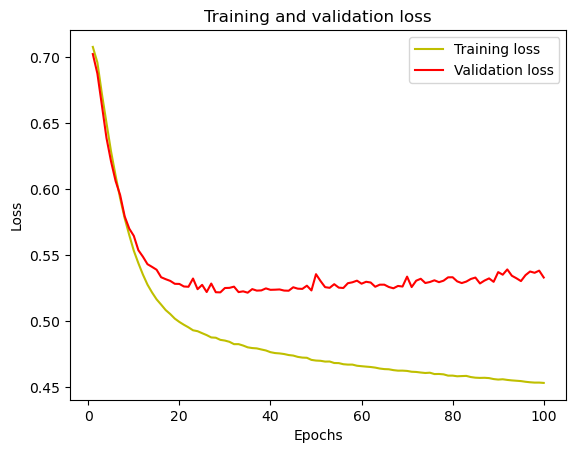

In [18]:
# Epoch에 따른 loss
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

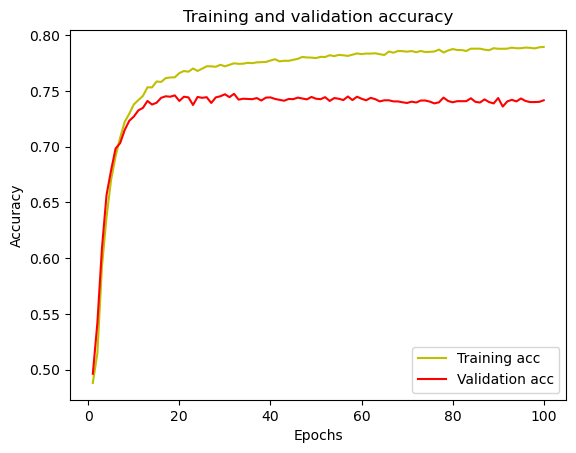

In [19]:
# Epoch에 따른 accuracy
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
# Word embedding
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(input_dim=300, 
                                  output_dim=16, 
                                  input_length=100))
model2.add(keras.layers.SimpleRNN(units=8,
                                  activation='tanh'))
model2.add(keras.layers.Dense(units=1,
                              activation='sigmoid'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           4800      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 5,009
Trainable params: 5,009
Non-trainable params: 0
_________________________________________________________________


In [25]:
model2.compile(optimizer=rmsprop,
               loss='binary_crossentropy',
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history2 = model2.fit(X_train, y_train,
                      validation_split=0.2,
                      batch_size=64,
                      epochs=100,
                      verbose=2,
                      callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 - 34s - loss: 0.6898 - accuracy: 0.5343 - val_loss: 0.6791 - val_accuracy: 0.5866 - 34s/epoch - 110ms/step
Epoch 2/100
313/313 - 35s - loss: 0.6685 - accuracy: 0.6176 - val_loss: 0.6572 - val_accuracy: 0.6612 - 35s/epoch - 111ms/step
Epoch 3/100
313/313 - 36s - loss: 0.6493 - accuracy: 0.6741 - val_loss: 0.6454 - val_accuracy: 0.6762 - 36s/epoch - 114ms/step
Epoch 4/100
313/313 - 32s - loss: 0.6366 - accuracy: 0.6924 - val_loss: 0.6341 - val_accuracy: 0.7050 - 32s/epoch - 101ms/step
Epoch 5/100
313/313 - 29s - loss: 0.6252 - accuracy: 0.7064 - val_loss: 0.6257 - val_accuracy: 0.7058 - 29s/epoch - 94ms/step
Epoch 6/100
313/313 - 29s - loss: 0.6140 - accuracy: 0.7182 - val_loss: 0.6158 - val_accuracy: 0.7114 - 29s/epoch - 91ms/step
Epoch 7/100
313/313 - 33s - loss: 0.6031 - accuracy: 0.7275 - val_loss: 0.6073 - val_accuracy: 0.7166 - 33s/epoch - 104ms/step
Epoch 8/100
313/313 - 32s - loss: 0.5922 - accuracy: 0.7352 - val_loss: 0.6032 - val_accuracy: 0.7080 - 32s/epoch

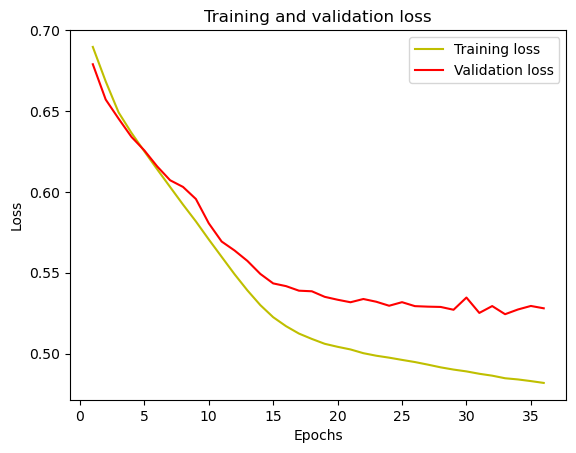

In [26]:
# Epoch에 따른 loss
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

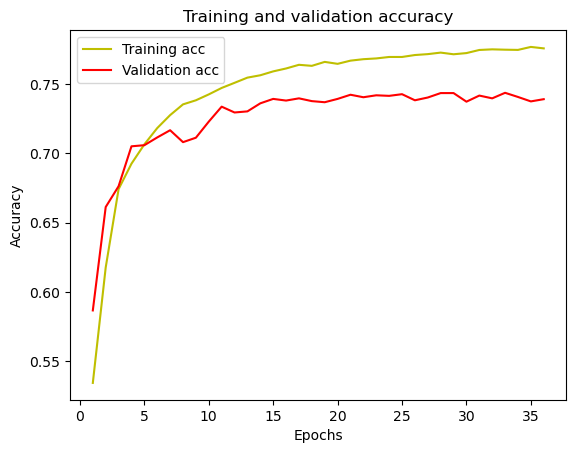

In [27]:
# Epoch에 따른 accuracy
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# References
https://youtu.be/9tb_g3Nc3to